In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
from skimage.transform import resize

In [2]:
data_dir = 'data/processed'

def load_data(data_dir):
    train = pd.read_json(data_dir+'/train.json')
    test = pd.read_json(data_dir+'/test.json')
    
    train.inc_angle=train.inc_angle.replace('na', 0)
    train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
    test.inc_angle = test.inc_angle.replace('na', 0)
    test.inc_angle = test.inc_angle.astype(float).fillna(0.0)
    return train, test

train, test = load_data(data_dir)

In [3]:
# Process data into images
def process_images(df):
    X_band1 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in df['band_1']])
    X_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df["band_2"]])
    # Merge bands and add another band as the mean of Band 1 and Band 2 (useful for the ImageDataGenerator later)
    imgs = np.concatenate([X_band1[:, :, :, np.newaxis]
                            , X_band2[:, :, :, np.newaxis]
                            ,((X_band1+X_band2)/2)[:, :, :, np.newaxis]], axis=-1)
    return imgs

X_train = process_images(train)
X_test = process_images(test)

X_angle_train = np.array(train.inc_angle)
X_angle_test = np.array(test.inc_angle)
y_train = np.array(train["is_iceberg"])

In [4]:
from tqdm import tqdm

width = 299

def resize_images(df):
    n = len(df)
    df_resized = np.zeros((n, width, width, 3), dtype=np.float32)
    for i in tqdm(range(n)):
        x = df[i]
        x = (x-x.min())/(x.max()-x.min()) # normalize for each pseudo pixel value
        df_resized[i] = resize(x, (299,299), mode='reflect')
    return df_resized

In [12]:
import cv2

def get_more_images(imgs):
    
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        ch=cv2.flip(c,0)
        
        vert_flip_imgs.append(np.dstack((av, bv, cv)))
        hori_flip_imgs.append(np.dstack((ah, bh, ch)))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h))
    
    return more_images

In [5]:
X_train = resize_images(X_train)
X_test = resize_images(X_test)

#Xtr_more = get_more_images(X_train) 
#Ytr_more = np.concatenate((y_train,y_train,y_train))

100%|██████████████████████████████████████████████████████████████████████████████| 8424/8424 [02:09<00:00, 65.28it/s]


In [6]:
# Create a train and validation split, 75% of data used in training
from sklearn.model_selection import train_test_split

X_train, X_valid, X_angle_train, X_angle_valid, y_train, y_valid = train_test_split(X_train,
                                    X_angle_train, y_train, random_state=666, train_size=0.75)

E:\software\anaconda\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
X_angle_train.shape

(1203,)

In [9]:
X_angle_valid.shape

(401,)

In [12]:
X_valid.shape

(401, 75, 75, 3)

In [11]:
y_train.shape

(1203,)

### Create ImageDataGenerator
Create a standard keras ImageDataGenerator, and then use a helper function to return multiple inputs as a list along with the y values necessary to train using fit_generator

In [7]:
from keras.preprocessing.image import ImageDataGenerator
batch_size=8
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 40)

# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow(X1, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=666)
    #genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=666)
    while True:
            X1i = genX1.next()
            #X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            #yield [X1i[0], X2i[1]], X1i[1]
            yield X1i[0], X1i[1]

# Finally create generator
gen_train_flow = gen_flow(X_train, y_train)
gen_valid_flow = gen_flow(X_valid, y_valid)

Using TensorFlow backend.


### build model

In [7]:
from keras.applications import VGG16
from keras.applications import ResNet50

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(75, 75, 3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0         
__________

In [15]:
from keras.applications import ResNet50
conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(width, width, 3))
conv_base.summary()

94658560/94653016 [==============================] - ETA: 8: - ETA: 5: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 56s - ETA: 52 - ETA: 49 - ETA: 46 - ETA: 42 - ETA: 39 - ETA: 37 - ETA: 34 - ETA: 33 - ETA: 31 - ETA: 29 - ETA: 28 - ETA: 27 - ETA: 25 - ETA: 24 - ETA: 23 - ETA: 22 - ETA: 21 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 13 - ETA: 12 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 1

bn3c_branch2c (BatchNormalizati (None, 37, 37, 512)  2048        res3c_branch2c[0][0]             
__________________________________________________________________________________________________
add_6 (Add)                     (None, 37, 37, 512)  0           bn3c_branch2c[0][0]              
                                                                 activation_16[0][0]              
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 37, 37, 512)  0           add_6[0][0]                      
__________________________________________________________________________________________________
res3d_branch2a (Conv2D)         (None, 37, 37, 128)  65664       activation_19[0][0]              
__________________________________________________________________________________________________
bn3d_branch2a (BatchNormalizati (None, 37, 37, 128)  512         res3d_branch2a[0][0]             
__________

res5a_branch2b (Conv2D)         (None, 10, 10, 512)  2359808     activation_41[0][0]              
__________________________________________________________________________________________________
bn5a_branch2b (BatchNormalizati (None, 10, 10, 512)  2048        res5a_branch2b[0][0]             
__________________________________________________________________________________________________
activation_42 (Activation)      (None, 10, 10, 512)  0           bn5a_branch2b[0][0]              
__________________________________________________________________________________________________
res5a_branch2c (Conv2D)         (None, 10, 10, 2048) 1050624     activation_42[0][0]              
__________________________________________________________________________________________________
res5a_branch1 (Conv2D)          (None, 10, 10, 2048) 2099200     activation_40[0][0]              
__________________________________________________________________________________________________
bn5a_branc

In [8]:
from keras.applications import InceptionV3
conv_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(width, width, 3))
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 35, 35, 64)   192         conv2d_20[0][0]                  
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 35, 35, 64)   192         conv2d_22[0][0]                  
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 35, 35, 96)   288         conv2d_25[0][0]                  
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 35, 35, 64)   192         conv2d_26[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 35, 35, 64)   0           batch_normalization_20[0][0]     
__________

__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 17, 17, 192)  576         conv2d_41[0][0]                  
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 17, 17, 192)  576         conv2d_44[0][0]                  
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 17, 17, 192)  576         conv2d_49[0][0]                  
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, 17, 17, 192)  576         conv2d_50[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, 17, 17, 192)  0           batch_normalization_41[0][0]     
__________

batch_normalization_74 (BatchNo (None, 17, 17, 192)  576         conv2d_74[0][0]                  
__________________________________________________________________________________________________
activation_74 (Activation)      (None, 17, 17, 192)  0           batch_normalization_74[0][0]     
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 17, 17, 192)  147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 17, 17, 192)  258048      activation_74[0][0]              
__________________________________________________________________________________________________
batch_normalization_71 (BatchNo (None, 17, 17, 192)  576         conv2d_71[0][0]                  
__________________________________________________________________________________________________
batch_norm

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_2[0][0]              
                                                                 activation_94[0][0]              
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


### Extract features

In [13]:
def extract_features(gen_flow, sample_count):
    features = np.zeros(shape=(sample_count, 2, 2, 512))
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in gen_flow:
        features_batch = conv_base.predict(inputs_batch)
        #print(features_batch.shape)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(gen_train_flow, len(X_train))
validation_features, validation_labels = extract_features(gen_valid_flow, len(X_valid))
#test_features, test_labels = extract_features(test_dir, 1000)

In [14]:
#The extracted features are currently of shape (samples, 4, 4, 512). We will feed them to a densely-connected classifier, so first we must flatten them to (samples, 8192):
train_features = np.reshape(train_features, (len(X_train), 2 * 2 * 512))
validation_features = np.reshape(validation_features, (len(X_valid), 2 * 2 * 512))
#test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [17]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=2 * 2 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=50,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 1203 samples, validate on 401 samples
Epoch 1/50
1203/1203 [==============================] - 3s 2ms/step - loss: 0.9333 - acc: 0.5303 - val_loss: 0.6819 - val_acc: 0.5586
Epoch 2/50
1203/1203 [==============================] - 2s 1ms/step - loss: 0.8888 - acc: 0.5403 - val_loss: 0.6415 - val_acc: 0.5835
Epoch 3/50
1203/1203 [==============================] - 2s 1ms/step - loss: 0.7992 - acc: 0.5877 - val_loss: 0.6200 - val_acc: 0.6110
Epoch 4/50
1203/1203 [==============================] - 2s 1ms/step - loss: 0.7832 - acc: 0.5943 - val_loss: 0.5970 - val_acc: 0.6359
Epoch 5/50
1203/1203 [==============================] - 2s 1ms/step - loss: 0.7365 - acc: 0.6201 - val_loss: 0.5827 - val_acc: 0.6409
Epoch 6/50
1203/1203 [==============================] - 2s 1ms/step - loss: 0.6573 - acc: 0.6359 - val_loss: 0.5751 - val_acc: 0.6758
Epoch 7/50
1203/1203 [==============================] - 2s 1ms/step - loss: 0.6645 - acc: 0.6567 - val_loss: 0.5652 - val_acc: 0.6808
Epoch 8/50
1203

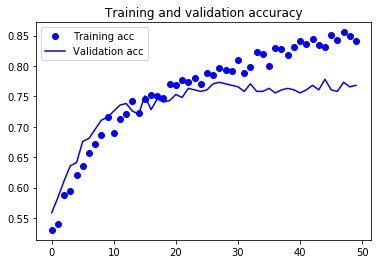

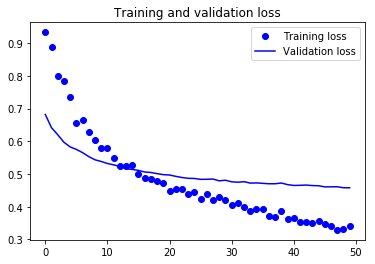

In [18]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
model.save('pretrained_model1.h5')

### Add pretrained net into model

In [25]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [9]:
from keras import models
from keras import layers

# InceptionV3 

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
conv_base.trainable = False

In [11]:
from keras import optimizers 
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

file_path = ".model_weights2.hdf5"
history = model.fit_generator(
      gen_train_flow,
      steps_per_epoch=100,
      epochs=30,
      validation_data=gen_valid_flow,
      validation_steps=50,
      callbacks=[ModelCheckpoint(file_path, save_best_only=True)],
      verbose=2)

Epoch 1/30
 - 55s - loss: 0.7052 - acc: 0.5463 - val_loss: 0.6595 - val_acc: 0.5900
Epoch 2/30
 - 33s - loss: 0.6140 - acc: 0.6337 - val_loss: 0.6302 - val_acc: 0.5903
Epoch 3/30
 - 31s - loss: 0.5091 - acc: 0.7387 - val_loss: 0.4898 - val_acc: 0.7303
Epoch 4/30
 - 32s - loss: 0.4647 - acc: 0.7809 - val_loss: 0.4211 - val_acc: 0.8015
Epoch 5/30
 - 32s - loss: 0.4243 - acc: 0.8125 - val_loss: 0.4115 - val_acc: 0.8270
Epoch 6/30
 - 36s - loss: 0.3982 - acc: 0.8200 - val_loss: 0.2946 - val_acc: 0.8753
Epoch 7/30
 - 26s - loss: 0.4403 - acc: 0.8042 - val_loss: 0.3009 - val_acc: 0.8677
Epoch 8/30
 - 26s - loss: 0.3786 - acc: 0.8412 - val_loss: 0.3148 - val_acc: 0.8422
Epoch 9/30
 - 27s - loss: 0.3447 - acc: 0.8625 - val_loss: 0.3086 - val_acc: 0.8779
Epoch 10/30
 - 26s - loss: 0.3749 - acc: 0.8529 - val_loss: 0.3074 - val_acc: 0.8702
Epoch 11/30
 - 31s - loss: 0.3510 - acc: 0.8317 - val_loss: 0.2864 - val_acc: 0.8982
Epoch 12/30
 - 32s - loss: 0.3360 - acc: 0.8688 - val_loss: 0.2590 - val_a

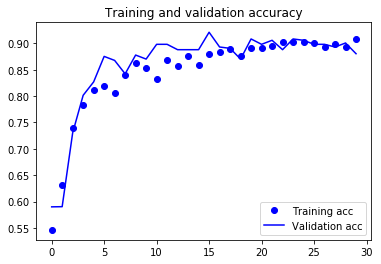

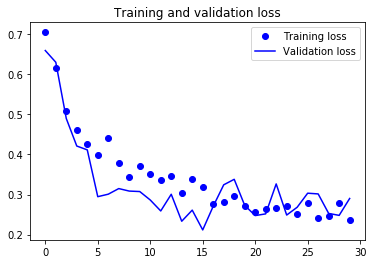

In [12]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
model.load_weights(filepath=file_path)
score = model.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

401/401 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 7ms/step
Test loss: 0.374893915698
Test accuracy: 0.857855361893


In [15]:
score

[0.37489391569782077, 0.85785536189329004]

### predict 

In [31]:
# Predict on test data
#test_predictions = model.predict([X_test,X_angle_test])
test_predictions = model.predict(X_test)

# Create .csv
pred_df = test[['id']].copy()
pred_df['is_iceberg'] = test_predictions
pred_df.to_csv('pretrained_model2.csv', index = False)

### fine tuning

In [37]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [18]:
from keras import models
from keras import layers

# InceptionV3 

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
#model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [19]:
from keras import optimizers 
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

file_path = ".model_weights3.hdf5"
history = model.fit_generator(
      gen_train_flow,
      steps_per_epoch=100,
      epochs=30,
      validation_data=gen_valid_flow,
      validation_steps=50,
      callbacks=[ModelCheckpoint(file_path, save_best_only=True)],
      verbose=2)

Epoch 1/30
 - 45s - loss: 0.3434 - acc: 0.8729 - val_loss: 0.2136 - val_acc: 0.9033
Epoch 2/30
 - 26s - loss: 0.2111 - acc: 0.9312 - val_loss: 0.2226 - val_acc: 0.9109
Epoch 3/30
 - 26s - loss: 0.2099 - acc: 0.9225 - val_loss: 0.2340 - val_acc: 0.9059
Epoch 4/30
 - 26s - loss: 0.2031 - acc: 0.9300 - val_loss: 0.2271 - val_acc: 0.9135
Epoch 5/30
 - 26s - loss: 0.2015 - acc: 0.9287 - val_loss: 0.2262 - val_acc: 0.9160
Epoch 6/30
 - 26s - loss: 0.2299 - acc: 0.9125 - val_loss: 0.2543 - val_acc: 0.9008
Epoch 7/30
 - 32s - loss: 0.2177 - acc: 0.9079 - val_loss: 0.2045 - val_acc: 0.9186
Epoch 8/30
 - 26s - loss: 0.2134 - acc: 0.9137 - val_loss: 0.2677 - val_acc: 0.9033
Epoch 9/30
 - 26s - loss: 0.1954 - acc: 0.9300 - val_loss: 0.2293 - val_acc: 0.9160
Epoch 10/30
 - 26s - loss: 0.2210 - acc: 0.9175 - val_loss: 0.2589 - val_acc: 0.9135
Epoch 11/30
 - 27s - loss: 0.2088 - acc: 0.9254 - val_loss: 0.2088 - val_acc: 0.9288
Epoch 12/30
 - 26s - loss: 0.1928 - acc: 0.9250 - val_loss: 0.2761 - val_a

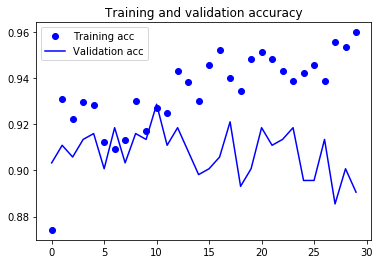

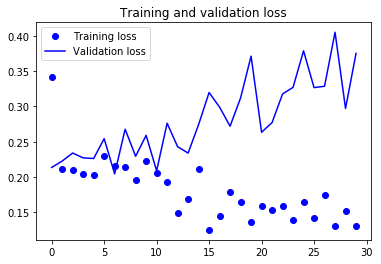

In [20]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
model.load_weights(filepath=file_path)
score = model.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

401/401 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 7ms/step
Test loss: 0.24809870384
Test accuracy: 0.902743142442


In [22]:
score

[0.2480987038398324, 0.90274314244191844]

In [24]:
test_predictions = model.predict(X_test)

# Create .csv
pred_df = test[['id']].copy()
pred_df['is_iceberg'] = test_predictions
pred_df.to_csv('pretrained_model3.csv', index = False)